# 一、配置基本环境

## 下载ZIP模式

In [1]:
import os
import sys

# 1. 确认数据集路径
dataset_path = '/kaggle/input/batteryml-main/BatteryML-main'
print("数据集内容:")
!ls -l {dataset_path}

# 2. 直接使用解压后的目录（无需解压）
extract_path = dataset_path  # 数据集已经是解压后的目录

# 3. 添加到 Python 路径
if extract_path not in sys.path:
    sys.path.insert(0, extract_path)
    print(f"\n已添加路径: {extract_path}")

# 4. 验证导入
try:
    # 尝试导入主包
    import batteryml
    print("\n✅ 成功导入 batteryml!")
    
    # 尝试导入特定模块
    from batteryml.builders import data_builder
    print("✅ 成功导入 data_builder!")
    
    # 测试使用
    db = data_builder.DataBuilder()
    data = db.load_data()
    print("\n示例数据:")
    print(data.head() if hasattr(data, 'head') else data[:5])
    
except ImportError as e:
    print(f"\n❌ 导入失败: {e}")
    print("尝试备用导入方法...")
    
    # 备用方法：直接导入子模块
    try:
        import sys
        # 添加子目录路径
        sys.path.append(f"{extract_path}/batteryml")
        
        from builders import data_builder
        print("✅ 通过子路径导入成功!")
        
    except Exception as e:
        print(f"❌ 最终导入失败: {e}")
        print("\n您可以手动导航到目录:")
        print(f"!ls {extract_path}/batteryml")

数据集内容:
total 700
-rw-r--r--  1 nobody nogroup 642332 Aug  4 10:17 baseline.ipynb
drwxr-xr-x 10 nobody nogroup      0 Aug  4 10:16 batteryml
drwxr-xr-x  2 nobody nogroup      0 Aug  4 10:16 bin
-rw-r--r--  1 nobody nogroup    444 Aug  4 10:17 CODE_OF_CONDUCT.md
drwxr-xr-x  5 nobody nogroup      0 Aug  4 10:16 configs
-rw-r--r--  1 nobody nogroup   4903 Aug  4 10:16 dataprepare.md
drwxr-xr-x  2 nobody nogroup      0 Aug  4 10:16 image
-rw-r--r--  1 nobody nogroup   1141 Aug  4 10:17 LICENSE
-rw-r--r--  1 nobody nogroup   9366 Aug  4 10:17 README.md
-rw-r--r--  1 nobody nogroup    116 Aug  4 10:16 requirements.txt
-rw-r--r--  1 nobody nogroup  13682 Aug  4 10:17 result.ipynb
-rw-r--r--  1 nobody nogroup   1123 Aug  4 10:16 run_all_rul_baseline.sh
-rw-r--r--  1 nobody nogroup   2757 Aug  4 10:16 SECURITY.md
-rw-r--r--  1 nobody nogroup   1073 Aug  4 10:16 setup.py
-rw-r--r--  1 nobody nogroup   9971 Aug  4 10:16 soh_example.ipynb

已添加路径: /kaggle/input/batteryml-main/BatteryML-main

❌ 导入失败:

## 导入模式

In [2]:
def setup_batteryml_imports():
    """设置 batteryml 模块导入"""
    import sys
    import os
    import shutil
    
    # 检查是否已经设置
    if 'batteryml' in sys.modules:
        return
    
    # 创建临时模块目录
    temp_module_dir = '/kaggle/working/temp_batteryml'
    os.makedirs(temp_module_dir, exist_ok=True)
    
    # 源文件根目录
    src_root = '/kaggle/input/batteryml-main/BatteryML-main'
    
    # 需要复制的目录和文件
    dirs_to_copy = [
        ('batteryml', ''),
        ('batteryml/visualization', 'plot_helper.py'),
        ('batteryml/data', 'battery_data.py')
    ]
    
    # 复制文件并创建包结构
    for rel_path, file_name in dirs_to_copy:
        dest_dir = os.path.join(temp_module_dir, rel_path)
        os.makedirs(dest_dir, exist_ok=True)
        
        # 创建 __init__.py
        init_file = os.path.join(dest_dir, '__init__.py')
        if not os.path.exists(init_file):
            open(init_file, 'w').close()
        
        # 复制特定文件
        if file_name:
            src_file = os.path.join(src_root, rel_path, file_name)
            dest_file = os.path.join(dest_dir, file_name)
            shutil.copy(src_file, dest_file)
    
    # 添加到 Python 路径
    sys.path.append(temp_module_dir)
    
    print(f"成功设置 batteryml 模块在 {temp_module_dir}")

# 在代码开头调用此函数
setup_batteryml_imports()

# 现在可以正常导入
from batteryml.visualization.plot_helper import plot_cycle_attribute
from batteryml.data.battery_data import BatteryData

成功设置 batteryml 模块在 /kaggle/working/temp_batteryml


## 运行,无SOC的图像与代码

In [3]:
import pickle
import pandas as pd
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import inspect
import glob

from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import medfilt
from typing import List, Tuple, Optional, Dict, Any


from batteryml.builders import FEATURE_EXTRACTORS
from batteryml.data.battery_data import BatteryData
from batteryml.feature.base import BaseFeatureExtractor
from batteryml.visualization import plot_helper
from batteryml.visualization.plot_helper import inner_plot_capacity_degradation, plot_capacity_degradation

import copy
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pprint

# 指定文件路径
file_path = '/kaggle/input/nasa-battery-data/B0018.pkl'

# 加载pickle文件,把所有.pkl文件塞进battery_data里
with open(file_path, 'rb') as f:
    battery_data = pickle.load(f)

# 打印对象类型
print(f"数据类型: {type(battery_data)}")

# 如果是字典，显示键列表
if isinstance(battery_data, dict):
    print("\n字典的键:")
    print(list(battery_data.keys()))
    
    # 检查是否有cycle_data
    if 'cycle_data' in battery_data and battery_data['cycle_data']:
        print("\n前5个循环数据:")
        for i, cycle in enumerate(battery_data['cycle_data'][:5]):
            print(f"\n循环 #{i+1}:")
            # 如果cycle是字典，打印其键
            if isinstance(cycle, dict):
                cycle_keys = list(cycle.keys())
                print(f"  循环数据键: {cycle_keys}")
                
                # 查看每个循环数据的内容摘要
                for key in cycle_keys:
                    if isinstance(cycle[key], list) and len(cycle[key]) > 0:
                        print(f"  {key}: 长度={len(cycle[key])}, 前3个值={cycle[key][:3]}")
                    else:
                        print(f"  {key}: {cycle[key]}")
            else:
                print(f"  {type(cycle)}")
    
    # 显示电池基本信息
    print("\n电池基本信息:")
    basic_info = {k: v for k, v in battery_data.items() if k != 'cycle_data' and not isinstance(v, list)}
    pprint.pprint(basic_info)
    
# 如果是BatteryData对象，显示其属性
else:
    print("\n电池ID:", getattr(battery_data, 'cell_id', 'N/A'))
    
    # 显示电池对象的属性
    print("\n电池对象属性:")
    for attr in dir(battery_data):
        if not attr.startswith('_') and not callable(getattr(battery_data, attr)):
            value = getattr(battery_data, attr)
            if isinstance(value, list) and attr == 'cycle_data' and len(value) > 0:
                print(f"{attr}: {len(value)}个循环")
                
                # 显示前10个循环数据的摘要
                print("\n前10个循环数据:")
                for i, cycle in enumerate(value[:10]):
                    print(f"\n循环 #{i+1} (循环编号: {getattr(cycle, 'cycle_number', 'N/A')}):")
                    for cycle_attr in dir(cycle):
                        if not cycle_attr.startswith('_') and not callable(getattr(cycle, cycle_attr)):
                            cycle_value = getattr(cycle, cycle_attr)
                            if isinstance(cycle_value, list) and len(cycle_value) > 0:
                                print(f"  {cycle_attr}: 长度={len(cycle_value)}, 前3个值={cycle_value[:3]}")
                            else:
                                print(f"  {cycle_attr}: {cycle_value}")
            elif not isinstance(value, list) or len(value) < 10:
                print(f"{attr}: {value}")
            else:
                print(f"{attr}: 长度={len(value)}, 类型={type(value[0])}")

数据类型: <class 'dict'>

字典的键:
['cell_id', 'cycle_data', 'form_factor', 'anode_material', 'cathode_material', 'electrolyte_material', 'nominal_capacity_in_Ah', 'depth_of_charge', 'depth_of_discharge', 'already_spent_cycles', 'max_voltage_limit_in_V', 'min_voltage_limit_in_V', 'max_current_limit_in_A', 'min_current_limit_in_A', 'reference', 'description', 'charge_protocol', 'discharge_protocol']

前5个循环数据:

循环 #1:
  循环数据键: ['cycle_number', 'current_in_A', 'voltage_in_V', 'charge_capacity_in_Ah', 'discharge_capacity_in_Ah', 'time_in_s', 'temperature_in_C', 'internal_resistance_in_ohm']
  cycle_number: 1
  current_in_A: 长度=366, 前3个值=[0.0001306673415663, 0.0014590806056812, -2.005671955333404]
  voltage_in_V: 长度=366, 前3个值=[4.188108651124536, 4.188195942647034, 3.977432055654197]
  charge_capacity_in_Ah: None
  discharge_capacity_in_Ah: 长度=366, 前3个值=[0.0, 2.080361827634158e-06, 0.0028332501952994904]
  time_in_s: 长度=366, 前3个值=[0.0, 9.421999999999995, 19.578000000000003]
  temperature_in_C: 长度=3

In [5]:
import sys
import os
import glob
import matplotlib.pyplot as plt

# 添加 battery_data.py 所在目录到 Python 路径
battery_data_path = '/kaggle/input/batteryml-main/BatteryML-main/batteryml/data/battery_data.py'
battery_data_dir = os.path.dirname(battery_data_path)
sys.path.append(battery_data_dir)

# 导入 BatteryData
from battery_data import BatteryData

In [6]:
import glob
# 使用通配符匹配所有.pkl文件
pickle_files = glob.glob("/kaggle/input/nasa-battery-data/*.pkl")

# 打印结果
print(f"找到 {len(pickle_files)} 个pkl文件:")
for file in pickle_files:
    print(file)

找到 4 个pkl文件:
/kaggle/input/nasa-battery-data/B0007.pkl
/kaggle/input/nasa-battery-data/B0006.pkl
/kaggle/input/nasa-battery-data/B0005.pkl
/kaggle/input/nasa-battery-data/B0018.pkl


In [7]:
# 加载第一个电池数据
first_battery = BatteryData.load(pickle_files[0])
print(f"成功加载电池: {first_battery.cell_id}")

成功加载电池: B0007


B0007


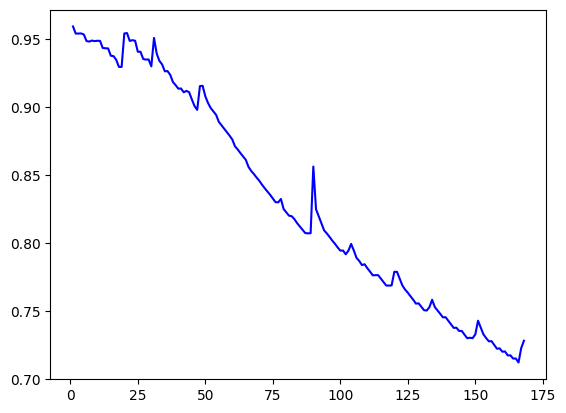

In [8]:
#如何处理.pkl文件的BatteryData对象的【字典】格式？
# 直接使用BatteryData.load方法（将字典转化为类）
first_battery = BatteryData.load(pickle_files[0])

# 现在first_battery是BatteryData对象，可以正常使用
print(first_battery.cell_id)
inner_plot_capacity_degradation(first_battery, normalize=True, color='blue', 
                                label=f'电池 {first_battery.cell_id}')

In [9]:
# 加载所有pickle文件为BatteryData对象
all_batteries = []
for file_path in pickle_files:
    try:
        # 使用BatteryData.load方法直接加载为BatteryData对象
        battery = BatteryData.load(file_path)
        all_batteries.append(battery)
        print(f"已加载电池 {battery.cell_id}")
    except Exception as e:
        print(f"加载 {os.path.basename(file_path)} 时出错: {e}")

已加载电池 B0007
已加载电池 B0006
已加载电池 B0005
已加载电池 B0018


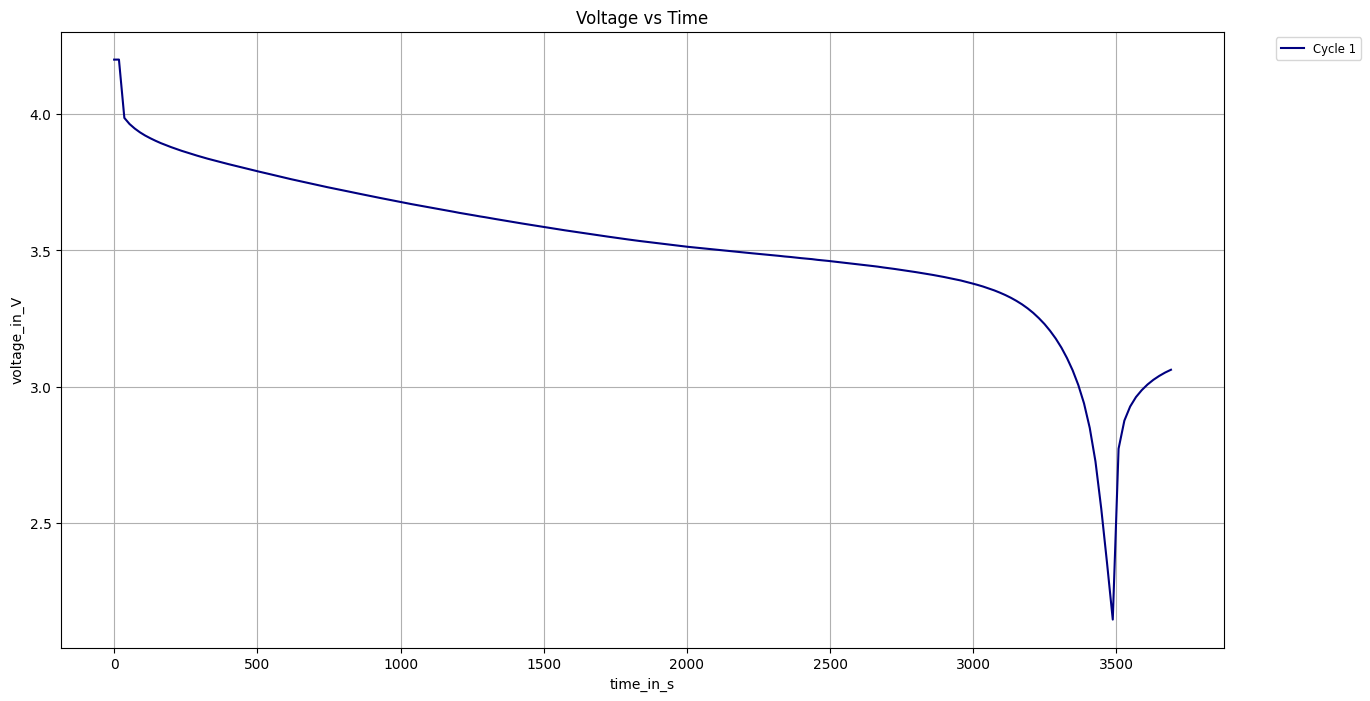

In [10]:
from batteryml.visualization.plot_helper import plot_cycle_attribute

# 绘制电压-时间图像
plot_cycle_attribute(
    cycle_infos=first_battery.cycle_data,        # 传入循环数据 #first_battery = BatteryData.load(pickle_files[0])
    key_fea='voltage_in_V',                # y轴：电压
    x_feature='time_in_s',                 # x轴：时间（默认值）
    title='Voltage vs Time',
    cycle_start=0,                         # 起始循环
    cycle_end=1,                          # 结束循环（显示前1个循环）
    #cycle_start=0, cycle_end=1 意思是取 first_battery.cycle_data[0:1]
    figsize=(15, 8)
)

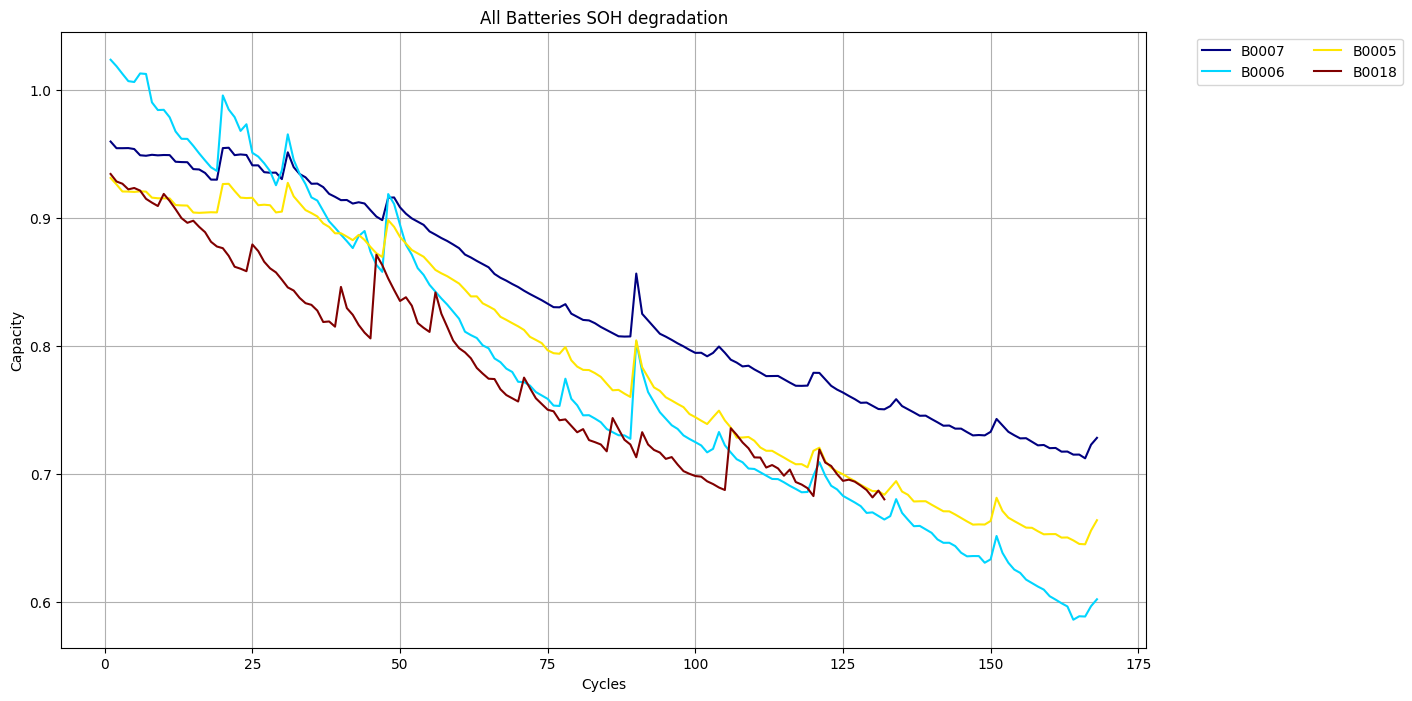

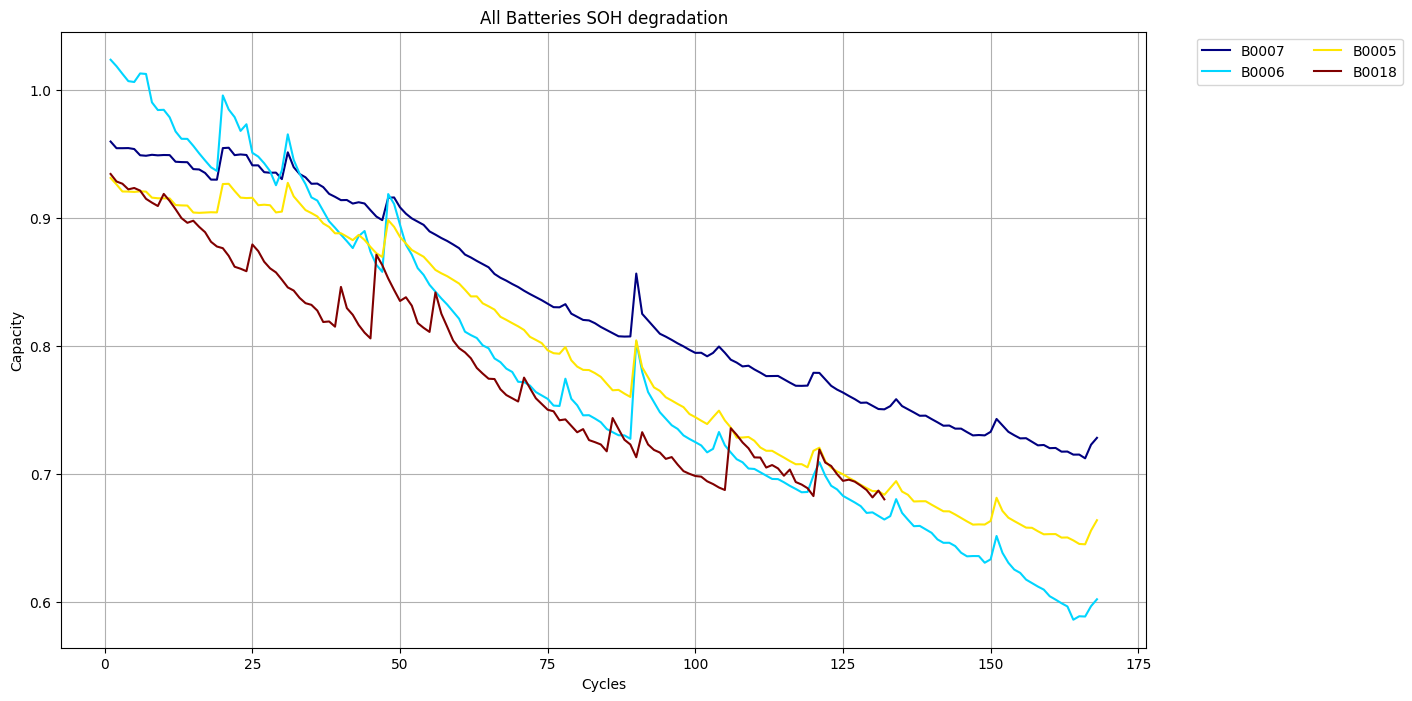

成功绘制了 4 个电池的容量衰减曲线


In [11]:
# 如果成功加载了电池数据，则绘制所有电池的容量衰减曲线
if all_batteries:
    plot_capacity_degradation(all_batteries, 
                             figsize=(14, 8), 
                             normalize=True, 
                             title='All Batteries SOH degradation',
                             n_legend_cols=2)
#plot_capacity_degradation函数中的纵轴"Capacity"具体含义取决于函数的normalize参数：
#当normalize=True时（默认设置）。纵轴表示的是SOH（健康状态），即当前循环的最大放电容量与标称容量的比值
#当normalize=False时。纵轴表示的是实际放电容量值，单位为Ah
    display(plt.gcf())
    plt.show()
    print(f"成功绘制了 {len(all_batteries)} 个电池的容量衰减曲线")
else:
    print("没有成功加载任何电池数据")

#### 绘图修改